In [1]:
# Import libraries
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import nibabel as nib
from sklearn.svm import SVR
import sklearn.model_selection as sms
import sklearn.linear_model as skl
import sklearn.preprocessing as skp
from sklearn.pipeline import Pipeline
import sklearn.metrics as skm
import SimpleITK as sitk
import six
from radiomics import featureextractor 
import numpy as np
import os
import pickle
import pandas as pd
import logging
from scipy.stats import linregress
import smogn
import pandas
from collections import Counter
from multiprocessing import Pool
from notebook import notebookapp
from numpy import matlib
import random
from scipy import ndimage
from util import pyvis
from util import extract
from loader import data_loader
from IPython.display import HTML
import util
import smogn
from smogn.phi import phi
from smogn.phi_ctrl_pts import phi_ctrl_pts
import warnings
from multiprocessing import Pool
import sklearn.linear_model as skl
import sklearn.neural_network as snn
import sklearn.feature_selection as skf
from imbalanced_regression import fds
import scipy
from scipy.ndimage import gaussian_filter1d
from scipy.signal.windows import triang
from scipy.ndimage import convolve1d
import scipy.stats as stats
import torch
from torch.nn import KLDivLoss


For the dataset $\{(\mathbf{x}_i,y_i)\}^N_{i=1}$ with feature space $\mathbf{x} \in \mathbb{R}^d$ and label $y_i \in \mathbb{R}$:

In [2]:
# Get case IDs
case_list = open('/home/ali/RadDBS-QSM/data/docs/cases_90','r')
lines = case_list.read()
lists = np.loadtxt(case_list.name,comments="#", delimiter=",",unpack=False,dtype=str)
case_id = []
for lines in lists:     
    case_id.append(lines[-9:-7])

# Load scores
file_dir = '/home/ali/RadDBS-QSM/data/docs/QSM anonymus- 6.22.2023-1528.csv'
motor_df = util.filter_scores(file_dir,'pre-dbs updrs','stim','CORNELL ID')
# Find cases with all required scores
subs,pre_imp,post_imp,pre_updrs_off = util.get_full_cases(motor_df,
                                                          'CORNELL ID',
                                                          'OFF (pre-dbs updrs)',
                                                          'ON (pre-dbs updrs)',
                                                          'OFF meds ON stim 6mo')
# Load extracted features
npy_dir = '/home/ali/RadDBS-QSM/data/npy/'
phi_dir = '/home/ali/RadDBS-QSM/data/phi/phi/'
roi_path = '/data/Ali/atlas/mcgill_pd_atlas/PD25-subcortical-labels.csv'
n_rois = 6
Phi_all, X_all, R_all, K_all, ID_all = util.load_featstruct(phi_dir,npy_dir+'X/',npy_dir+'R/',npy_dir+'K/',n_rois,1595,False)
ids = np.asarray(ID_all).astype(int)
# Find overlap between scored subjects and feature extraction cases
c_cases = np.intersect1d(np.asarray(case_id).astype(int),np.asarray(subs).astype(int))
# Complete case indices with respect to feature matrix
c_cases_idx = np.in1d(ids,c_cases)
X_all_c = X_all[c_cases_idx,:,:]
K_all_c = K_all[c_cases_idx,:,:]
R_all_c = R_all[c_cases_idx,:,:]
# Re-index the scored subjects with respect to complete cases
s_cases_idx = np.in1d(subs,ids[c_cases_idx])
pre_imp = pre_imp[s_cases_idx]
post_imp = post_imp[s_cases_idx]
pre_updrs_off = pre_updrs_off[s_cases_idx]
per_change = post_imp

Allocated arrays
Created feature matrix
Created ROI matrix
Created feature label matrix


Text(0, 0.5, 'Frequency')

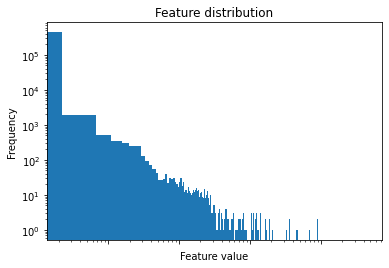

In [3]:
fig, ax = plt.subplots()
h = plt.hist(X_all_c.ravel(),bins=10000)
ax.loglog()
ax.set_xticklabels([])
plt.title('Feature distribution')
plt.xlabel('Feature value')
plt.ylabel('Frequency')

Text(0, 0.5, 'Frequency')

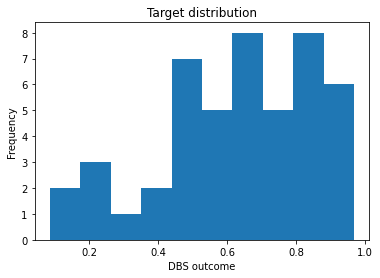

In [4]:
plt.hist(per_change)
plt.title('Target distribution')
plt.xlabel('DBS outcome')
plt.ylabel('Frequency')

In [5]:
# Assign the anchor target to the median
anchor = np.min(per_change)


In [6]:
X0 = X_all_c.reshape(X_all_c.shape[0],X_all_c.shape[1]*X_all_c.shape[2])
arr1inds = per_change.argsort()
X0 = X0[arr1inds[::-1]]
per_change = per_change[arr1inds[::-1]]
aj = np.where(per_change==anchor)
aj = aj[0][0]
# sel = skf.SelectKBest(skf.r_regression,k=2000)
# X0_s = sel.fit_transform(X0,per_change)
X0_s = X0
X0_ss = skp.StandardScaler().fit_transform(X0_s)

In [7]:
C0 = np.zeros((1,len(per_change))).T
C0_s = np.zeros((1,len(per_change))).T

for j in np.arange(len(per_change)):
    C0[j] = skm.pairwise.cosine_similarity(np.expand_dims(X0[aj,:],axis=0),
                                        np.expand_dims(X0[j,:],axis=0))
    C0_s[j] = skm.pairwise.cosine_similarity(np.expand_dims(X0_ss[aj,:],axis=0),
                                        np.expand_dims(X0_ss[j,:],axis=0))

Text(0.5, 1.0, 'Standard')

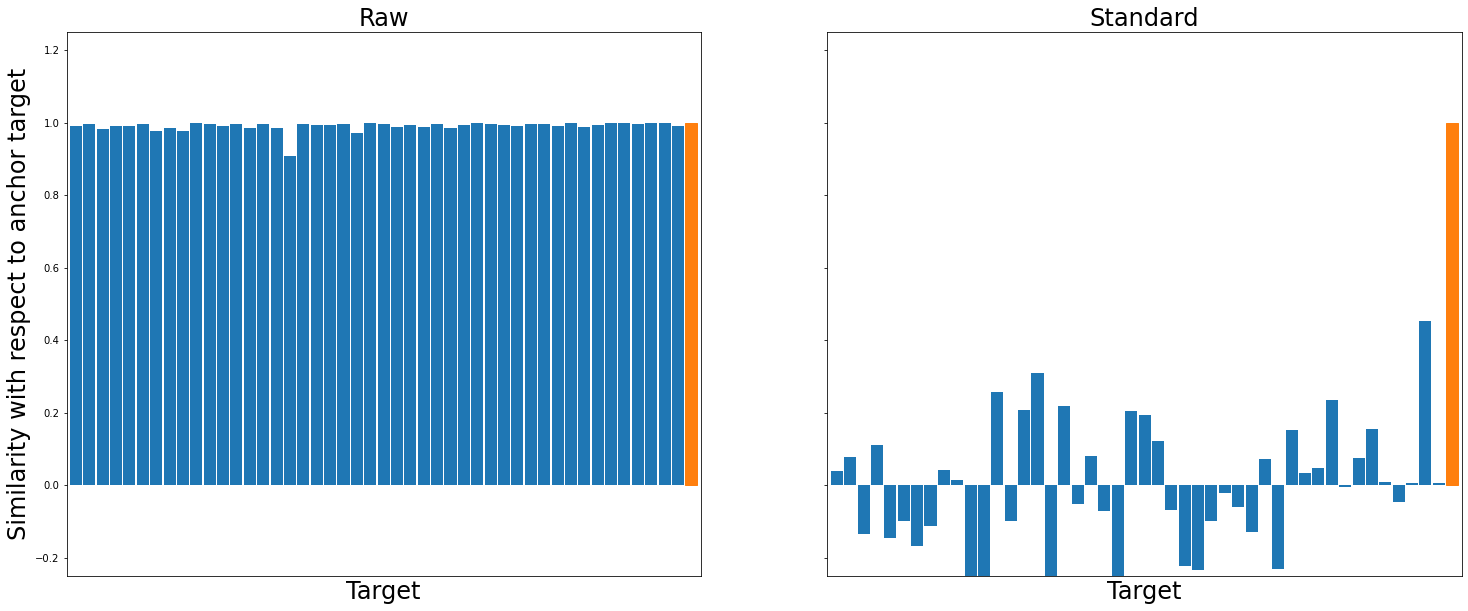

In [18]:
fig, ax = plt.subplots(1,2,figsize=(25,10),sharey=True)
pd.DataFrame(C0,index=per_change).plot.bar(ax=ax[0],legend=False,width=0.9)
ax[0].set_xticks([])
ax[0].get_children()
ax[0].get_children()[aj].set_color('#ff7f0e') 
ax[0].set_ylim([-0.25,1.25])
ax[0].set_ylabel('Similarity with respect to anchor target',fontsize=24)
ax[0].set_xlabel('Target',fontsize=24)
ax[0].set_title('Raw',fontsize=24)
pd.DataFrame(C0_s,index=sorted(per_change)).plot.bar(ax=ax[1],legend=False,width=0.9)
ax[1].set_xticks([])
ax[1].get_children()
ax[1].get_children()[aj].set_color('#ff7f0e') 
ax[1].set_xlabel('Target',fontsize=24)
ax[1].set_title('Standard',fontsize=24)


Define the structure $\mathcal{Y}$ which can be divided into $\mathcal{B}$ groups 
$$[y_0,y_1),[y_1,y_2),...[y_{B-1},y_B)$$
Where $\mathcal{B}=\{1,...,B\} \in \mathbb{Z^+}$, or the index space. The defined bins give a minimum resolution for the regression task
$$\delta y \overset{\Delta}{=}y_{b+1}-y_b$$
For (learned) feature space, let $z=f(\mathbf{x},\theta)$, where $f$ if is a deep neural network parameterized by $\theta$. Then, the final prediction is $\hat{y}=g(z)$. \
\
Both features $\mathbf{z}$ and labels $y$ will be smoothed with a symmetric kernel $k(x,x')$. Begin with feature distribution smoothing over $N_b$ bins
$$\mathbf{\mu}_b=\frac{1}{N_b} \sum_{i=1}^{N_b} \mathbf{z}_i$$
$$\mathbf{\Sigma}_b=\frac{1}{N_b-1} \sum_{i=1}^{N_b} (\mathbf{z}_i-\mathbf{\mu}_b)(\mathbf{z}_i-\mathbf{\mu}_b)^T

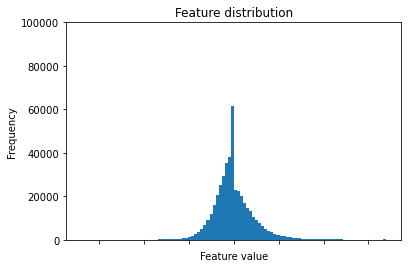

In [10]:
B = 100
mu_b = []
s_b = []
fig, ax = plt.subplots()
h = plt.hist(X0_ss.ravel(),bins=B)
ax.set_xticklabels([])
ax.set_ylim([0,1e5])
plt.title('Feature distribution')
plt.xlabel('Feature value')
plt.ylabel('Frequency')
for j in np.arange(B):
    mu_b.append((1/h[0][j])*np.sum(X0_ss.ravel()[(h[1][j] < X0_ss.ravel()) & (X0_ss.ravel() < h[1][j+1])]))
    s_b.append((1/(h[0][j]-1))*np.sum((X0_ss.ravel()[(h[1][j] < X0_ss.ravel()) & (X0_ss.ravel() < h[1][j+1])]-mu_b[j])**2))


In [11]:
S_b = np.asarray(s_b)
S_b[np.isnan(S_b)] = 0
Mu_b = np.asarray(mu_b)

Both features $\mathbf{z}$ and labels $y$ will be smoothed with a symmetric kernel $k(x,x')$. Begin with feature distribution smoothing over $N_b$ bins
$$\tilde{\mathbf{\mu}}_b=\sum_{b' \in \mathcal{B}} k(y_b,y_{b'}) \mathbf{\mu}_{b'}$$
$$\tilde{\mathbf{\Sigma}}_b=\sum_{b' \in \mathcal{B}}k(y_b,y_{b'}) \mathbf{\Sigma}_{b'}

In [12]:
def get_lds_kernel_window(kernel, ks, sigma):
    assert kernel in ['gaussian', 'triang', 'laplace']
    half_ks = (ks - 1) // 2
    if kernel == 'gaussian':
        base_kernel = [0.] * half_ks + [1.] + [0.] * half_ks
        kernel_window = gaussian_filter1d(base_kernel, sigma=sigma) / max(gaussian_filter1d(base_kernel, sigma=sigma))
    elif kernel == 'triang':
        kernel_window = triang(ks)
    else:
        laplace = lambda x: np.exp(-abs(x) / sigma) / (2. * sigma)
        kernel_window = list(map(laplace, np.arange(-half_ks, half_ks + 1))) / max(map(laplace, np.arange(-half_ks, half_ks + 1)))

    return kernel_window

Mut_b = gaussian_filter1d(Mu_b, sigma=2)
St_b = gaussian_filter1d(S_b, sigma=2)

Text(0.5, 0.98, 'Gaussian filtering')

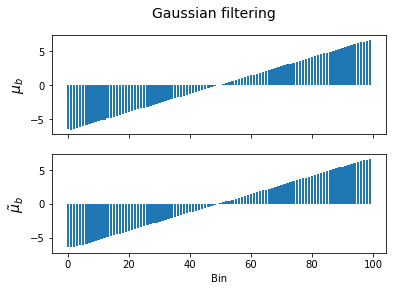

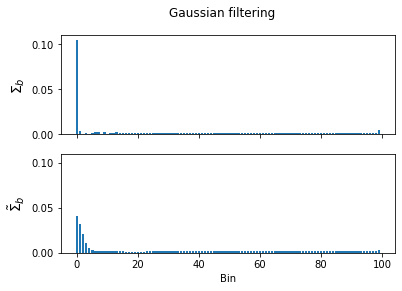

In [13]:
fig, ax = plt.subplots(2,1,sharex=True,sharey=True)
ax[0].bar(np.arange(B),Mu_b)
ax[0].set_ylabel(r'$\mu_b$',fontsize=14)
ax[1].bar(np.arange(B),Mut_b)
ax[1].set_ylabel(r'$\tilde{\mu}_b$',fontsize=14)
ax[1].set_xlabel('Bin')
plt.suptitle('Gaussian filtering',fontsize=14)
fig, ax = plt.subplots(2,1,sharex=True,sharey=True)
ax[0].bar(np.arange(B),S_b)
ax[0].set_ylabel(r'$\Sigma_b$',fontsize=14)
ax[1].bar(np.arange(B),St_b)
ax[1].set_ylabel(r'$\tilde{\Sigma}_b$',fontsize=14)
ax[1].set_xlabel('Bin')
plt.suptitle('Gaussian filtering')


The features can be whitened and recolored accoring to Sun et. al
$$\tilde{z}=\tilde{\mathbf{\Sigma}}^{\frac{1}{2}}_b\mathbf{\Sigma}^{-\frac{1}{2}}_b(z-\mathbf{\mu}_b)+\tilde{\mathbf{\mu}}_b

In [14]:
z = np.zeros_like(X0_ss.ravel())
idx = 0
for j in np.arange(B):
    x = X0_ss.ravel()[(h[1][j] < X0_ss.ravel()) & (X0_ss.ravel() < h[1][j+1])]
    z[idx:idx+len(x)] = x
    mu_zb = Mu_b[j]
    mut_zb = Mut_b[j]
    s_zb = S_b[j]
    st_zb = St_b[j]
    idx = idx+len(x)


In [15]:
zt = np.sqrt(st_zb)/np.sqrt(s_zb)*(z-mu_zb)+mut_zb

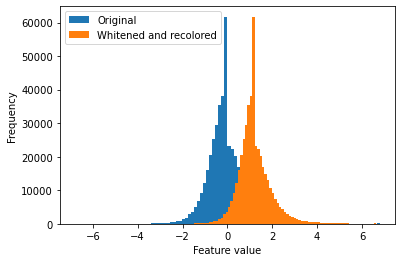

In [16]:
h0 = plt.hist(X0_ss.ravel(),bins=B,label='Original')
h = plt.hist(zt.ravel(),bins=B,label='Whitened and recolored')
plt.xlabel('Feature value')
plt.ylabel('Frequency')
plt.legend()